# Linear regression with batch gradient descent

## Goal
To fit a cloud of data points
$$\{(x_1, y_1), \dots, (x_N, y_N)\}$$
with a affine (linear) map
$$x\mapsto y=b+mx\,.$$

## Optimization
The approximating affine map is obtained by successive approximations,
$$ y = b^{(n)} + m^{(n)}x\qquad n=1, 2, \dots, N$$
using mini-batch gradient descent.  To this end we will PyTorch `DataLoader`s.

## Evaluation
For comparison, we plot the linear regression derived analytically in `Scikit-Learn`.


## Note on `PyTorch` functionalities
In this notebook we use the following functionalities provided with `PyTorch`:
- automatic differentiation with the `backward()` function
- dataloaders for easier handling of (mini) batches

Other `PyTorch` features that are not used in this notebook:
- update of model parameters via optimizers
- `torch.nn.Modules`, especially convenient for more complex architecture (not needed for linear regression)

---
tags: pytorch, tutorial, linear regression, dataloader, mini batch gradient descent, visualization, tick locator

# Imports

In [1]:
from sklearn.linear_model import LinearRegression # for comparison
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Helper functions

In [2]:
def mse(preds, targs):
    return ((preds - targs)**2).sum()

# Data

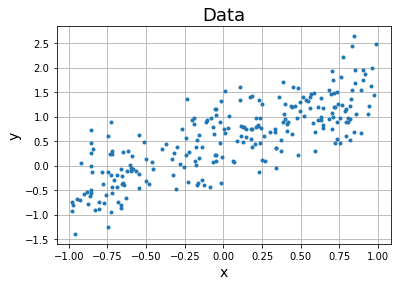

In [3]:
# Number of samples
n_batches = 8
batch_size = 34
N = (n_batches - 1)*batch_size + batch_size//4 # size of dataset

# Samples
x = (-1 + 2*torch.rand(1, N)).view(-1, 1)
sigma = .5
h = sigma*torch.randn(1, N).view(-1, 1)
targs = .5 + x + h

# Dataset
ds = TensorDataset(x, targs)

# Dataloader
dl = DataLoader(ds, batch_size, shuffle=False)

# Visualization
plt.plot(x, targs,'.');
plt.xlabel("x",  fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Data", fontsize=18)
plt.grid();

# Ordinary least squares linear regression
Calculate the linear regressor using closed form using `sklearn`:

In [4]:
linreg = LinearRegression()
linreg.fit(x, targs)

preds_lms = linreg.predict(x)
loss_lms = mse(targs.numpy(), preds_lms)
print(f"{'Slope':<10} m={linreg.coef_[0,0]:.4f}")
print(f"{'Intercept':<10} b={linreg.intercept_[0]:.4f}")
print(f"{'Loss':<10} L={loss_lms:.4f}")

Slope      m=1.0408
Intercept  b=0.5101
Loss       L=51.7900


# Linear model

In [5]:
model = nn.Linear(1, 1)

# Initialize to fixed values for easier inspection
model.weight.data[0] = -1.
model.bias.data[0] = 0.

losses = []
weights = []
biases = []

# Training

In [6]:
lr = .002
n_epochs = 10

for epoch in range(n_epochs):
    for x_b, targs_b in dl:
        
        preds_b = model.forward(x_b)
        loss_b = mse(preds_b, targs_b)
        loss_b.backward()
        
        with torch.no_grad():
            preds = model.forward(x)
            loss = mse(preds, targs)

        for param in model.parameters():
            with torch.no_grad():
                param -= lr*param.grad.item()
            param.grad.zero_()
        weights.append(model.weight.item())
        biases.append(model.bias.item())
        losses.append(loss.item())

# Visualization

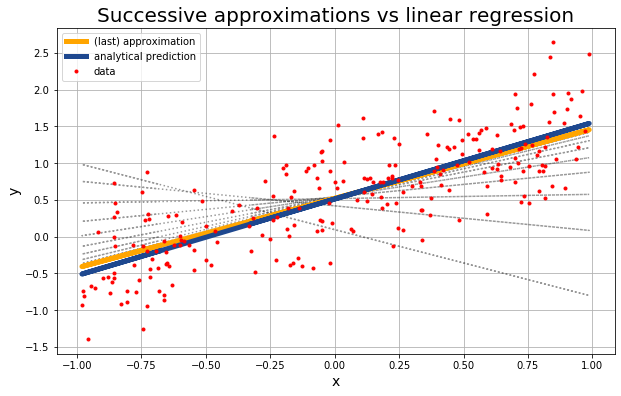

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

for w, b in zip(weights[::n_batches], biases[::n_batches]):
    preds = w*x+b
    
    ax.plot(x, preds.detach().numpy(), 'k:', alpha=.4)
ax.plot(x, preds.detach().numpy(), 'Orange', label='(last) approximation', linewidth=5) # last iteration
ax.plot(x, preds_lms, 'xkcd:cobalt', label='LSE regressor', linewidth=5)
ax.plot(x, targs, linestyle='', marker='.', color='r', label='data');

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title("Successive approximations vs linear regression", fontsize=20);
ax.legend();
ax.grid();

# Successive losses

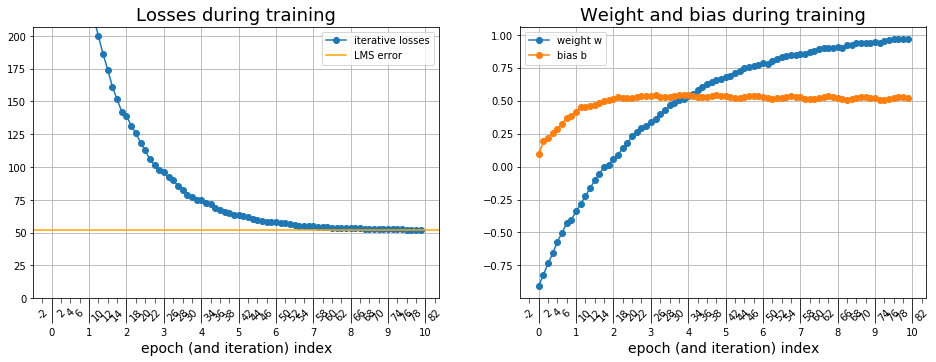

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
ax.plot(losses, 'o-', label='iterative losses')
ax.axhline(loss_lms, color='Orange', label='LMS error')
ax.grid();
ax.legend();
ax.set_xlabel("iteration index", fontsize=14);
ax.set_title("Losses during training", fontsize=18);
# ax.set_ylim([0, max(losses).item() + 1]);
ax.set_ylim(0, min(4*loss_lms, max(losses) + 1))

ax = axs[1]

ax.plot(weights, 'o-', label='weight w')
ax.plot(biases, 'o-', label='bias b')
ax.grid();
ax.legend();
ax.set_title("Weight and bias during training", fontsize=18);

for ax in axs:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(n_batches))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(n_batches//4))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{t//n_batches:.0f}"))
    ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda t, pos: f"{t:.0f}"))
    ax.tick_params(which='major', axis='x', length=25)
    ax.tick_params(which='minor', labelrotation=45, length=5)
    ax.set_xlabel("epoch (and iteration) index", fontsize=14);

